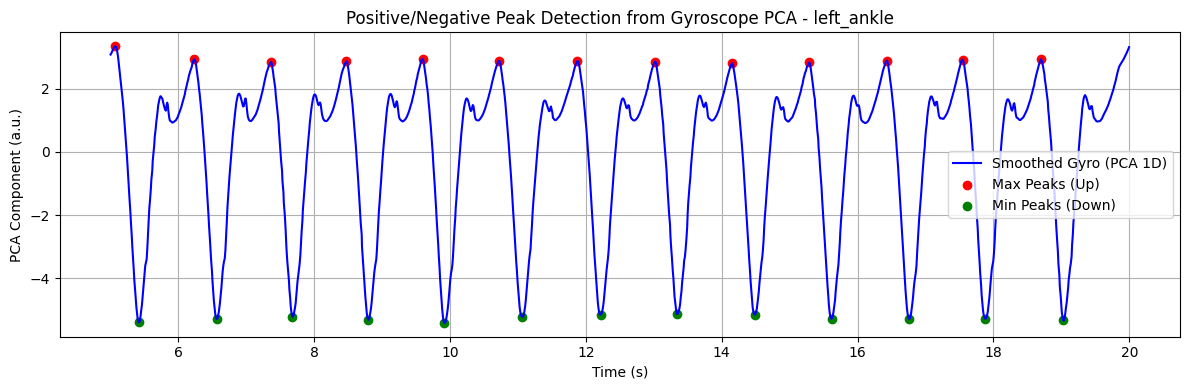

-------- left_ankle analysis --------
평균 step length: 69.43 cm
걸음 수: 24
보행 시간: 14.99 s
보행 속도: 4.00 km/h


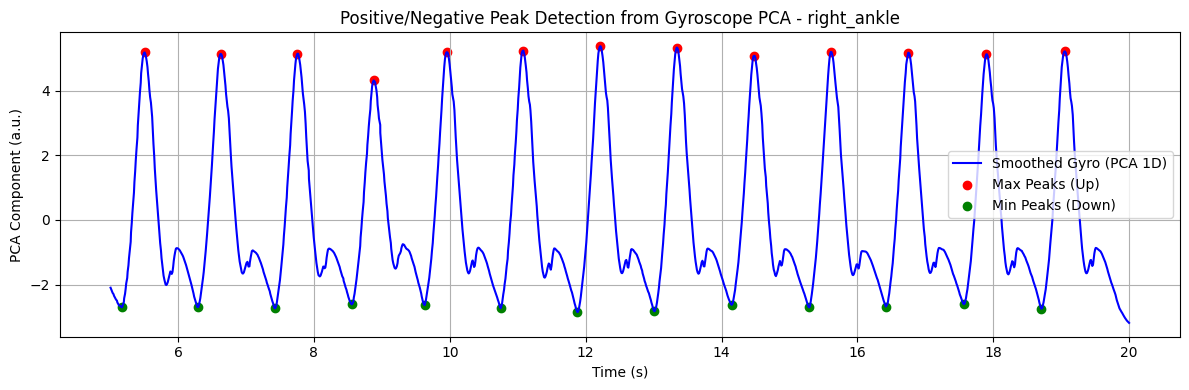

-------- right_ankle analysis --------
평균 step length: 69.24 cm
걸음 수: 24
보행 시간: 14.99 s
보행 속도: 3.99 km/h


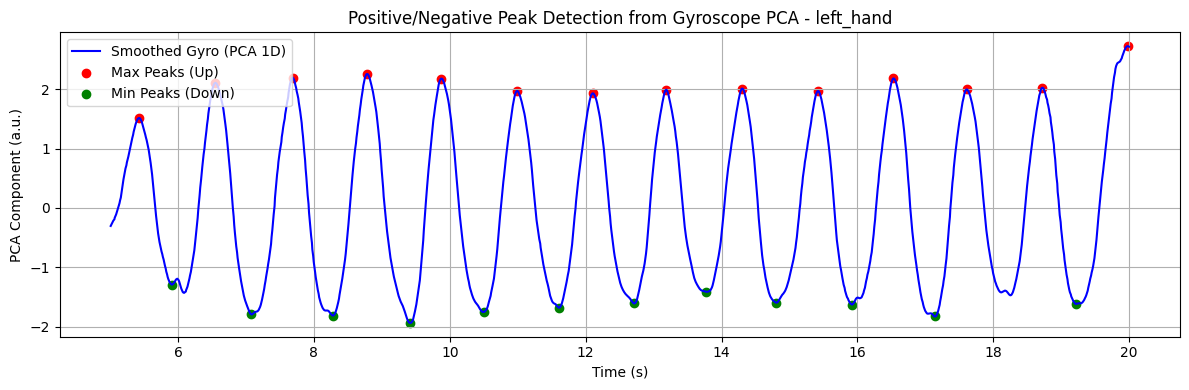

-------- left_hand analysis --------
평균 step length: 68.26 cm
걸음 수: 24
보행 시간: 14.99 s
보행 속도: 3.93 km/h


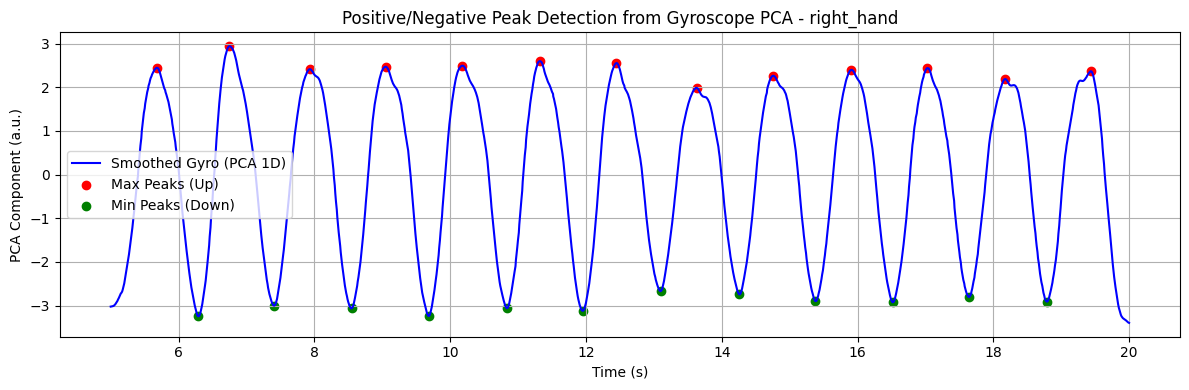

-------- right_hand analysis --------
평균 step length: 69.40 cm
걸음 수: 23
보행 시간: 15.00 s
보행 속도: 3.83 km/h


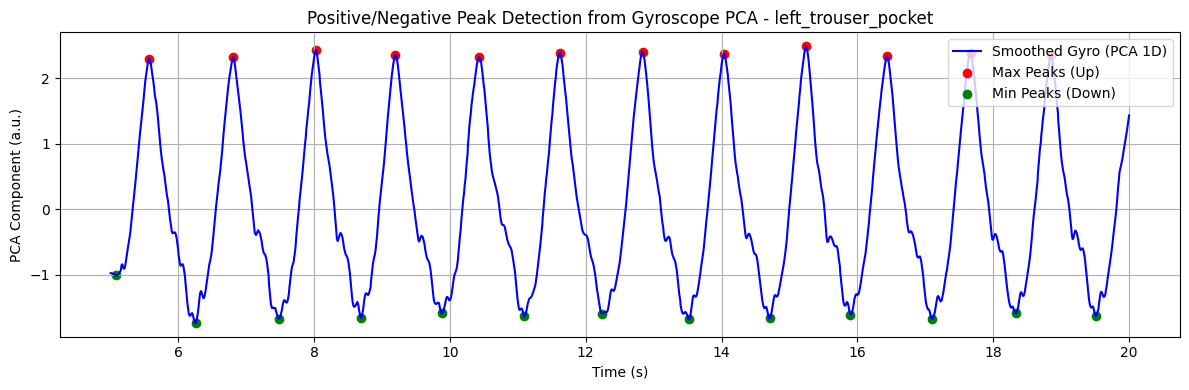

-------- left_trouser_pocket analysis --------
평균 step length: 66.62 cm
걸음 수: 23
보행 시간: 14.99 s
보행 속도: 3.68 km/h


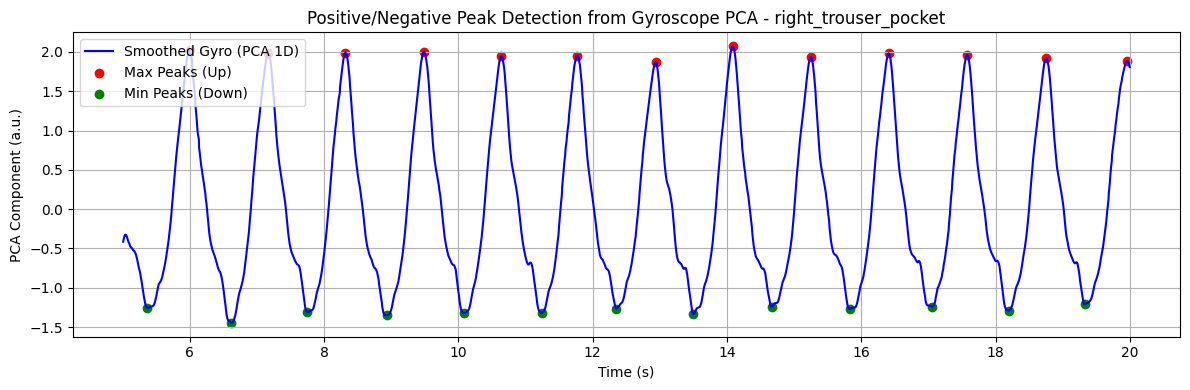

-------- right_trouser_pocket analysis --------
평균 step length: 63.60 cm
걸음 수: 24
보행 시간: 14.99 s
보행 속도: 3.67 km/h


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from geopy.distance import geodesic

sensor_files = {
    'left_ankle': 'left_ankle_calibrate.csv',
    'right_ankle': 'right_ankle_calibrate.csv',
    'left_hand': 'left_hand_calibrate.csv',
    'right_hand': 'right_hand_calibrate.csv',
    'left_trouser_pocket': 'left_trouser_pocket_calibrate.csv',
    'right_trouser_pocket': 'right_trouser_pocket_calibrate.csv'
}
sensor_files_test = {
    'left_ankle': 'left_ankle_test.csv',
    'right_ankle': 'right_ankle_test.csv',
    'left_hand': 'left_hand_test.csv',
    'right_hand': 'right_hand_test.csv',
    'left_trouser_pocket': 'left_trouser_pocket_test.csv',
    'right_trouser_pocket': 'right_trouser_pocket_test.csv'
}


for sensor, file_path in sensor_files_test.items():
    df = pd.read_csv(file_path)

    # preprocessing about time
    df['time'] = pd.to_datetime(df['time'])
    start_time = df['time'].iloc[0]
    df['time'] = (df['time'] - start_time).dt.total_seconds()
    df = df[(df['time'] >= 5) & (df['time'] < 20)].reset_index(drop=True)

    # 1D dimensionality reduction of gyroscope data using pca and smoothing using sliding window
    gyro_data = df[['wx', 'wy', 'wz']].dropna().values
    pca = PCA(n_components=1)
    gyro_pca = pca.fit_transform(gyro_data).flatten()
    gyro_smooth = pd.Series(gyro_pca).rolling(window=30, min_periods=1, center=True).mean()

    # find up peak
    peaks_max, _ = find_peaks(gyro_smooth, distance=100)

    # find down peak
    peaks_min, _ = find_peaks(-gyro_smooth, distance=100)

    # 시각화
    plt.figure(figsize=(12, 4))
    plt.plot(df['time'][:len(gyro_smooth)], gyro_smooth, label='Smoothed Gyro (PCA 1D)', color='blue')
    plt.scatter(df['time'].iloc[peaks_max], gyro_smooth.iloc[peaks_max], color='red', label='Max Peaks (Up)')
    plt.scatter(df['time'].iloc[peaks_min], gyro_smooth.iloc[peaks_min], color='green', label='Min Peaks (Down)')
    plt.title(f"Positive/Negative Peak Detection from Gyroscope PCA - {sensor}")
    plt.xlabel("Time (s)")
    plt.ylabel("PCA Component (a.u.)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    a_z = df['az']
    Ks = {'ankle': 0.72, 'hand': 0.95, 'pocket': 0.66}
    if 'ankle' in sensor:
      K = Ks['ankle']
    elif 'hand' in sensor:
      K = Ks['hand']
    elif 'pocket' in sensor:
      K = Ks['pocket']
    else:
      K = 0.0

    stride_lengths = []
    # get stride lengths of up peak
    for i in range(len(peaks_max) - 1):
        start = peaks_max[i]
        end = peaks_max[i + 1]
        a_segment = a_z[start:end]
        A_max = np.max(a_segment)
        A_min = np.min(a_segment)
        stride = K * ((A_max - A_min ) ** (1/4))
        stride_lengths.append(stride)
    # get stride lengths of down peak
    for i in range(len(peaks_min) - 1):
        start = peaks_min[i]
        end = peaks_min[i + 1]
        a_segment = a_z[start:end]
        A_max = np.max(a_segment)
        A_min = np.min(a_segment)
        stride = K * ( (A_max - A_min) ** (1/4))
        stride_lengths.append(stride)

    # Step length = stride length / 2
    step_lengths = [s / 2 for s in stride_lengths]
    total_steps = len(step_lengths)
    total_distance_m = sum(step_lengths)  # in meters

    # Walking time (in seconds)
    walking_time_sec = df['time'].iloc[-1] - df['time'].iloc[0]

    # Speed in km/h
    speed_mps = total_distance_m / walking_time_sec
    speed_kmh = speed_mps * 3.6

    print(f"-------- {sensor} analysis --------")
    print(f"평균 step length: {np.mean(step_lengths)*100:.2f} cm")
    print(f"걸음 수: {total_steps}")
    print(f"보행 시간: {walking_time_sec:.2f} s")
    print(f"보행 속도: {speed_kmh:.2f} km/h")